# v19 Training - Cross-Lingual SPLADE with Separate Korean/English Loss

This notebook trains the v19 Korean-English cross-lingual SPLADE model.

## Key Features:
- **Model**: xlm-roberta-large (560M parameters)
- **Dataset**: v19_high_quality (1:N mixed Korean/English with similarity scores)
- **Format**: `{"ko": "프로그램", "terms": [{"term": "program", "sim": 0.95}, ...]}`

## Critical Fix: Separate Korean/English Target Losses

**Problem**: The previous training failed because Korean targets naturally get high activation 
from shared subword tokens, while English targets require cross-lingual transfer. The combined 
loss was dominated by Korean, causing the model to ignore English.

**Solution**:
- Separate Korean target loss (`lambda_ko_target=3.0`)
- Separate English target loss (`lambda_en_target=10.0`) - **3.3x higher weight!**
- Best model selection prioritizes English activation: `score = KO + 2*EN`

This ensures the model learns proper cross-lingual expansion from Korean to English.

In [1]:
import sys
from pathlib import Path

# Find project root
def find_project_root():
    """Find project root by looking for markers like pyproject.toml or src/"""
    current = Path.cwd()
    for parent in [current] + list(current.parents):
        if (parent / "pyproject.toml").exists() or (parent / "src").exists():
            return parent
    return Path.cwd().parent.parent

PROJECT_ROOT = find_project_root()
sys.path.insert(0, str(PROJECT_ROOT))

print(f"Project root: {PROJECT_ROOT}")

Project root: /home/west/Documents/cursor-workspace/opensearch-neural-pre-train


In [2]:
import json
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.amp import GradScaler, autocast
from transformers import AutoTokenizer, get_linear_schedule_with_warmup
from tqdm.notebook import tqdm

from src.model.splade_model import create_splade_model

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

PyTorch version: 2.10.0.dev20251109+cu130
CUDA available: True
GPU: NVIDIA GB10
GPU Memory: 128.5 GB


/home/west/Documents/cursor-workspace/opensearch-neural-pre-train/.venv/lib/python3.12/site-packages/torch/cuda/__init__.py:435: UserWarning: 
    Found GPU0 NVIDIA GB10 which is of cuda capability 12.1.
    Minimum and Maximum cuda capability supported by this version of PyTorch is
    (8.0) - (12.0)
    
  queued_call()


## 1. Configuration

In [ ]:
# Training Configuration
CONFIG = {
    # Model
    "model_name": "xlm-roberta-large",
    "max_length": 64,

    # Data - 1:N mixed format (Korean -> [Korean + English terms])
    "data_path": PROJECT_ROOT / "dataset" / "v19_high_quality" / "term_mappings.jsonl",

    # Training - adjusted for larger batch size
    "batch_size": 64,
    "gradient_accumulation_steps": 2,
    "num_epochs": 15,
    "learning_rate": 3e-6,
    "warmup_ratio": 0.1,
    "max_grad_norm": 1.0,

    # Loss weights - SEPARATE weights for Korean and English
    "lambda_self": 2.0,         # Korean source preservation
    "lambda_ko_target": 3.0,    # Korean synonym activation (easier)
    "lambda_en_target": 10.0,   # English translation activation (harder, needs higher weight!)
    "lambda_margin": 3.0,       # Margin loss
    "lambda_negative": 1.0,     # Suppress non-target tokens
    "lambda_sparsity": 0.05,    # Increased from 0.01 to suppress noise tokens
    "target_margin": 2.0,

    # Mixed precision
    "use_fp16": True,

    # Output
    "output_dir": PROJECT_ROOT / "outputs" / "v19_xlm_large",
}

print("Training Configuration:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

# Calculate training stats
dataset_size = 13684  # from data
batches_per_epoch = dataset_size // CONFIG["batch_size"]
opt_steps_per_epoch = batches_per_epoch // CONFIG["gradient_accumulation_steps"]
total_opt_steps = opt_steps_per_epoch * CONFIG["num_epochs"]

print(f"\nTraining Stats:")
print(f"  Effective batch size: {CONFIG['batch_size'] * CONFIG['gradient_accumulation_steps']}")
print(f"  Batches per epoch: ~{batches_per_epoch}")
print(f"  Optimization steps per epoch: ~{opt_steps_per_epoch}")
print(f"  Total optimization steps: ~{total_opt_steps}")
print(f"\n*** Key: lambda_en_target={CONFIG['lambda_en_target']} >> lambda_ko_target={CONFIG['lambda_ko_target']} ***")
print(f"*** lambda_sparsity={CONFIG['lambda_sparsity']} (increased to suppress noise tokens) ***")

## 2. Helper Functions

In [4]:
def is_korean_char(c: str) -> bool:
    """Check if character is Korean."""
    return (
        "\uac00" <= c <= "\ud7a3"
        or "\u1100" <= c <= "\u11ff"
        or "\u3130" <= c <= "\u318f"
    )


def is_english_char(c: str) -> bool:
    """Check if character is English."""
    return c.isalpha() and c.isascii()


def is_non_target_token(token: str) -> bool:
    """Check if token is from non-target language (not Korean or English)."""
    clean = token.replace("\u2581", "").replace("##", "")  # Remove subword markers
    if not clean:
        return False

    has_korean = any(is_korean_char(c) for c in clean)
    has_english = any(is_english_char(c) for c in clean)

    if has_korean or has_english:
        return False

    # Check for other languages
    has_japanese = any(
        "\u3040" <= c <= "\u309f" or "\u30a0" <= c <= "\u30ff" for c in clean
    )
    has_cjk = any("\u4e00" <= c <= "\u9fff" for c in clean)
    has_cyrillic = any("\u0400" <= c <= "\u04ff" for c in clean)
    has_arabic = any("\u0600" <= c <= "\u06ff" for c in clean)
    has_thai = any("\u0e00" <= c <= "\u0e7f" for c in clean)
    has_greek = any("\u0370" <= c <= "\u03ff" for c in clean)

    return (
        has_japanese or has_cjk or has_cyrillic or has_arabic or has_thai or has_greek
    )

## 3. Dataset Class - Separate Korean/English Targets

Dataset for 1:N mixed Korean/English term mappings with similarity scores:
- Input format: `{"ko": "프로그램", "terms": [{"term": "program", "sim": 0.95}, {"term": "소프트웨어", "sim": 0.88}]}`

**Key Change**: Separates Korean and English targets into distinct lists:
- `ko_target_ids` / `ko_target_weights`: Korean synonym tokens
- `en_target_ids` / `en_target_weights`: English translation tokens

This enables separate loss computation for cross-lingual training.

In [5]:
class TermMappingDataset(Dataset):
    """Dataset for 1:N Korean to mixed Korean/English term mappings with similarity.
    
    Format: {"ko": "프로그램", "terms": [{"term": "program", "sim": 0.95}, ...]}
    
    Separates Korean and English targets for explicit cross-lingual training.
    """

    def __init__(self, data_path: Path, tokenizer, max_length: int = 64):
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.data = []
        
        # Build set of special token IDs to exclude
        self.special_ids = {
            tokenizer.pad_token_id,
            tokenizer.cls_token_id,
            tokenizer.sep_token_id,
            tokenizer.unk_token_id,
            tokenizer.bos_token_id,
            tokenizer.eos_token_id,
        }
        self.special_ids = {t for t in self.special_ids if t is not None}
        
        # Add tokens by name
        for token_name in ['<s>', '</s>', '<pad>', '<unk>', '<mask>']:
            tid = tokenizer.convert_tokens_to_ids(token_name)
            if tid != tokenizer.unk_token_id:
                self.special_ids.add(tid)

        print(f"Loading dataset from {data_path}...")
        print(f"Special token IDs to exclude: {len(self.special_ids)}")

        def is_korean_term(text: str) -> bool:
            """Check if term contains Korean characters."""
            return any('\uac00' <= c <= '\ud7a3' for c in text)

        total_ko_targets = 0
        total_en_targets = 0

        with open(data_path, "r", encoding="utf-8") as f:
            for line in tqdm(f, desc="Loading data"):
                item = json.loads(line.strip())

                ko_term = item.get("ko", "")
                terms_data = item.get("terms", [])

                if not ko_term or not terms_data:
                    continue

                # Tokenize Korean source term (exclude special tokens)
                ko_tokens = tokenizer.tokenize(ko_term)
                ko_token_ids = tokenizer.convert_tokens_to_ids(ko_tokens)
                ko_token_ids = [
                    tid for tid in ko_token_ids 
                    if tid != tokenizer.unk_token_id and tid not in self.special_ids
                ]

                # SEPARATE Korean and English targets
                ko_target_weights: dict = {}  # Korean target tokens
                en_target_weights: dict = {}  # English target tokens
                
                for term_info in terms_data:
                    # Handle both old format (string) and new format (dict)
                    if isinstance(term_info, dict):
                        term = term_info.get("term", "")
                        sim = term_info.get("sim", 1.0)
                    else:
                        term = term_info
                        sim = 1.0
                    
                    # Determine if Korean or English
                    is_korean = is_korean_term(term)
                    
                    # Lowercase for consistency (affects English only)
                    term_lower = term if is_korean else term.lower()
                    tokens = tokenizer.tokenize(term_lower)
                    token_ids = tokenizer.convert_tokens_to_ids(tokens)
                    
                    for tid in token_ids:
                        # Exclude unknown and special tokens
                        if tid != tokenizer.unk_token_id and tid not in self.special_ids:
                            if is_korean:
                                ko_target_weights[tid] = max(ko_target_weights.get(tid, 0.0), sim)
                            else:
                                en_target_weights[tid] = max(en_target_weights.get(tid, 0.0), sim)

                # Only include samples that have both source and at least one target
                if ko_token_ids and (ko_target_weights or en_target_weights):
                    total_ko_targets += len(ko_target_weights)
                    total_en_targets += len(en_target_weights)
                    
                    self.data.append(
                        {
                            "ko_term": ko_term,
                            "ko_token_ids": ko_token_ids,
                            "ko_target_ids": list(ko_target_weights.keys()),
                            "ko_target_weights": list(ko_target_weights.values()),
                            "en_target_ids": list(en_target_weights.keys()),
                            "en_target_weights": list(en_target_weights.values()),
                        }
                    )

        print(f"Loaded {len(self.data):,} valid term mappings")
        
        # Statistics
        samples_with_english = sum(1 for d in self.data if d["en_target_ids"])
        print(f"Samples with English targets: {samples_with_english:,} ({samples_with_english/len(self.data)*100:.1f}%)")
        print(f"Total Korean target tokens: {total_ko_targets:,}")
        print(f"Total English target tokens: {total_en_targets:,}")
        
        # Weight statistics
        all_ko_weights = [w for d in self.data for w in d["ko_target_weights"]]
        all_en_weights = [w for d in self.data for w in d["en_target_weights"]]
        if all_ko_weights:
            print(f"Korean target similarity: mean={sum(all_ko_weights)/len(all_ko_weights):.3f}")
        if all_en_weights:
            print(f"English target similarity: mean={sum(all_en_weights)/len(all_en_weights):.3f}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]

        encoding = self.tokenizer(
            item["ko_term"],
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "ko_token_ids": item["ko_token_ids"],
            "ko_target_ids": item["ko_target_ids"],
            "ko_target_weights": item["ko_target_weights"],
            "en_target_ids": item["en_target_ids"],
            "en_target_weights": item["en_target_weights"],
        }


def collate_fn(batch):
    """Custom collate function."""
    return {
        "input_ids": torch.stack([item["input_ids"] for item in batch]),
        "attention_mask": torch.stack([item["attention_mask"] for item in batch]),
        "ko_token_ids": [item["ko_token_ids"] for item in batch],
        "ko_target_ids": [item["ko_target_ids"] for item in batch],
        "ko_target_weights": [item["ko_target_weights"] for item in batch],
        "en_target_ids": [item["en_target_ids"] for item in batch],
        "en_target_weights": [item["en_target_weights"] for item in batch],
    }

## 4. Loss Function - Cross-Lingual with Separate Korean/English

**Critical Design Decision**: Separate Korean and English target losses.

Why? When the input is Korean (e.g., "머신러닝"):
- Korean targets (e.g., "딥러닝") share subword tokens → naturally high activation
- English targets (e.g., "machine", "learning") have no overlap → need explicit training

Without separation, Korean dominates the loss and English is ignored.

In [6]:
class CrossLingualLoss(nn.Module):
    """Loss function for cross-lingual term mapping with SEPARATE Korean/English losses.
    
    Key insight: Korean targets naturally get high activation from shared subword tokens,
    but English targets require explicit cross-lingual transfer. We separate the losses
    to ensure English targets get proper training signal.
    
    Components:
    - Self loss: Preserve Korean source term tokens
    - Korean target loss: Activate Korean synonym tokens (easier, shared subwords)
    - English target loss: Activate English translation tokens (harder, cross-lingual)
    - Margin loss: Ensure minimum activation for all target tokens
    - Negative loss: Suppress non-target language tokens
    """

    def __init__(self, target_margin: float = 2.0, non_target_ids: torch.Tensor = None):
        super().__init__()
        self.target_margin = target_margin
        self.non_target_ids = non_target_ids

    def forward(
        self,
        sparse_rep,
        ko_token_ids,
        ko_target_ids,
        ko_target_weights,
        en_target_ids,
        en_target_weights,
    ):
        """
        Args:
            sparse_rep: Sparse representations [batch_size, vocab_size]
            ko_token_ids: List of Korean source token IDs per sample
            ko_target_ids: List of Korean target token IDs per sample
            ko_target_weights: List of similarity weights for Korean targets
            en_target_ids: List of English target token IDs per sample
            en_target_weights: List of similarity weights for English targets
        """
        batch_size = sparse_rep.shape[0]
        device = sparse_rep.device

        self_loss = torch.tensor(0.0, device=device)
        ko_target_loss = torch.tensor(0.0, device=device)
        en_target_loss = torch.tensor(0.0, device=device)
        margin_loss = torch.tensor(0.0, device=device)
        negative_loss = torch.tensor(0.0, device=device)

        n_valid = 0
        n_with_english = 0

        for i in range(batch_size):
            rep = sparse_rep[i]

            # Self loss: maximize activation of Korean source tokens
            if ko_token_ids[i]:
                ko_ids = torch.tensor(ko_token_ids[i], device=device)
                ko_activations = rep[ko_ids]
                self_loss = self_loss - torch.log(ko_activations + 1e-8).mean()

            # Korean target loss: activate Korean synonym tokens
            if ko_target_ids[i]:
                tgt_ids = torch.tensor(ko_target_ids[i], device=device)
                tgt_weights = torch.tensor(ko_target_weights[i], device=device, dtype=torch.float32)
                tgt_activations = rep[tgt_ids]
                
                # Weighted log loss
                weighted_log_loss = -torch.log(tgt_activations + 1e-8) * tgt_weights
                ko_target_loss = ko_target_loss + weighted_log_loss.sum() / (tgt_weights.sum() + 1e-8)
                
                # Margin loss for Korean targets
                margin_violations = F.relu(self.target_margin - tgt_activations) * tgt_weights
                margin_loss = margin_loss + margin_violations.sum() / (tgt_weights.sum() + 1e-8)

            # English target loss: activate English translation tokens (CRITICAL!)
            if en_target_ids[i]:
                n_with_english += 1
                tgt_ids = torch.tensor(en_target_ids[i], device=device)
                tgt_weights = torch.tensor(en_target_weights[i], device=device, dtype=torch.float32)
                tgt_activations = rep[tgt_ids]
                
                # Weighted log loss for English tokens
                weighted_log_loss = -torch.log(tgt_activations + 1e-8) * tgt_weights
                en_target_loss = en_target_loss + weighted_log_loss.sum() / (tgt_weights.sum() + 1e-8)
                
                # Margin loss for English targets (higher margin for cross-lingual)
                en_margin = self.target_margin * 1.5  # Stronger margin for English
                margin_violations = F.relu(en_margin - tgt_activations) * tgt_weights
                margin_loss = margin_loss + margin_violations.sum() / (tgt_weights.sum() + 1e-8)

            # Negative loss: suppress non-target language tokens
            if self.non_target_ids is not None:
                non_target_ids_device = self.non_target_ids.to(device)
                non_target_activations = rep[non_target_ids_device]
                negative_loss = negative_loss + F.relu(
                    non_target_activations - 0.1
                ).mean()

            n_valid += 1

        if n_valid > 0:
            self_loss = self_loss / n_valid
            ko_target_loss = ko_target_loss / n_valid
            margin_loss = margin_loss / n_valid
            negative_loss = negative_loss / n_valid
        
        # English loss: only divide by samples that have English targets
        if n_with_english > 0:
            en_target_loss = en_target_loss / n_with_english

        return {
            "self": self_loss,
            "ko_target": ko_target_loss,
            "en_target": en_target_loss,
            "margin": margin_loss,
            "negative": negative_loss,
        }

## 5. Evaluation Function

In [7]:
# Test pairs for evaluation (Korean source -> expected Korean synonyms + English translations)
TEST_PAIRS = [
    # (source_ko, expected_english, expected_korean_synonyms)
    ("머신러닝", ["machine", "learning"], ["머신", "러닝", "기계학습"]),
    ("딥러닝", ["deep", "learning"], ["딥", "러닝", "심층학습"]),
    ("자연어처리", ["natural", "language", "processing"], ["자연어", "처리"]),
    ("인공지능", ["artificial", "intelligence"], ["인공", "지능"]),
    ("검색엔진", ["search", "engine"], ["검색", "엔진"]),
    ("데이터베이스", ["database"], ["데이터", "베이스"]),
    ("클라우드", ["cloud"], ["클라우드"]),
    ("서버", ["server"], ["서버"]),
    ("네트워크", ["network"], ["네트워크"]),
    ("추천시스템", ["recommend", "system"], ["추천", "시스템"]),
    ("추천", ["recommend", "recommendation"], ["추천"]),
    ("신경망", ["neural", "network"], ["신경망", "신경"]),
    ("강화학습", ["reinforcement", "learning"], ["강화", "학습"]),
    ("컴퓨터비전", ["computer", "vision"], ["컴퓨터", "비전"]),
    ("음성인식", ["speech", "recognition"], ["음성", "인식"]),
]


def evaluate_model(model, tokenizer, device, top_k=50):
    """Evaluate model on test pairs - check both Korean and English activation."""
    model.eval()

    ko_activated_total = 0
    en_activated_total = 0
    ko_expected_total = 0
    en_expected_total = 0

    with torch.no_grad():
        for ko_term, en_expected, ko_expected in TEST_PAIRS:
            encoding = tokenizer(
                ko_term,
                max_length=64,
                padding="max_length",
                truncation=True,
                return_tensors="pt",
            )

            with autocast("cuda", enabled=CONFIG["use_fp16"]):
                sparse_rep, _ = model(
                    encoding["input_ids"].to(device),
                    encoding["attention_mask"].to(device),
                )

            sparse_rep = sparse_rep[0].float().cpu()
            top_indices = torch.topk(sparse_rep, k=top_k).indices.tolist()
            top_tokens = tokenizer.convert_ids_to_tokens(top_indices)
            top_tokens_set = set(top_tokens)

            # Check Korean synonym/preservation activation
            for ko in ko_expected:
                ko_toks = tokenizer.tokenize(ko)
                for tok in ko_toks:
                    ko_expected_total += 1
                    if tok in top_tokens_set:
                        ko_activated_total += 1

            # Check English translation activation
            for en in en_expected:
                en_toks = tokenizer.tokenize(en.lower())
                for tok in en_toks:
                    en_expected_total += 1
                    if tok in top_tokens_set:
                        en_activated_total += 1

    model.train()

    ko_rate = (
        ko_activated_total / ko_expected_total * 100 if ko_expected_total > 0 else 0
    )
    en_rate = (
        en_activated_total / en_expected_total * 100 if en_expected_total > 0 else 0
    )

    return ko_rate, en_rate

## 6. Initialize Components

In [8]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# Load tokenizer
print(f"\nLoading tokenizer: {CONFIG['model_name']}...")
tokenizer = AutoTokenizer.from_pretrained(CONFIG["model_name"])
print(f"Vocab size: {tokenizer.vocab_size:,}")

Device: cuda

Loading tokenizer: xlm-roberta-large...
Vocab size: 250,002


In [9]:
# Build non-target language token ID list AND special tokens to suppress
print("Building token suppression lists...")

non_target_ids = []
special_token_ids = []

# Get special token IDs
special_tokens = {
    tokenizer.pad_token_id,
    tokenizer.cls_token_id,
    tokenizer.sep_token_id,
    tokenizer.unk_token_id,
    tokenizer.bos_token_id,
    tokenizer.eos_token_id,
}
special_tokens = {t for t in special_tokens if t is not None}

# Punctuation and symbols to suppress
suppress_patterns = {
    '.', ',', '!', '?', ':', ';', '-', '_', '(', ')', '[', ']', '{', '}',
    '"', "'", '`', '/', '\\', '@', '#', '$', '%', '^', '&', '*', '+', '=',
    '<', '>', '~', '|', '▶', '►', '●', '○', '■', '□', '★', '☆', '→', '←',
    '...', '..', '--', '==', '##', '@@',
}

for token_id in tqdm(range(tokenizer.vocab_size), desc="Scanning vocab"):
    token = tokenizer.convert_ids_to_tokens(token_id)
    
    # Special tokens
    if token_id in special_tokens:
        special_token_ids.append(token_id)
        continue
    
    # Check for special token markers
    if token in ['<s>', '</s>', '<pad>', '<unk>', '<mask>', '[CLS]', '[SEP]', '[PAD]', '[UNK]', '[MASK]']:
        special_token_ids.append(token_id)
        continue
    
    # Punctuation and symbols
    clean_token = token.replace('▁', '').replace('##', '').strip()
    if clean_token in suppress_patterns or (clean_token and all(c in suppress_patterns or not c.isalnum() for c in clean_token)):
        special_token_ids.append(token_id)
        continue
    
    # Non-target language (not Korean, not English)
    if is_non_target_token(token):
        non_target_ids.append(token_id)

# Combine for suppression
all_suppress_ids = list(set(non_target_ids + special_token_ids))
suppress_ids_tensor = torch.tensor(all_suppress_ids, dtype=torch.long)

print(f"Non-target language tokens: {len(non_target_ids):,}")
print(f"Special/punctuation tokens: {len(special_token_ids):,}")
print(f"Total tokens to suppress: {len(all_suppress_ids):,}")

Building token suppression lists...


Scanning vocab:   0%|          | 0/250002 [00:00<?, ?it/s]

Non-target language tokens: 76,209
Special/punctuation tokens: 2,481
Total tokens to suppress: 78,690


In [10]:
# Load dataset (1:N mixed format)
dataset = TermMappingDataset(CONFIG["data_path"], tokenizer, CONFIG["max_length"])

dataloader = DataLoader(
    dataset,
    batch_size=CONFIG["batch_size"],
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn,
    pin_memory=True,
)

print(f"\nDataset size: {len(dataset):,}")
print(f"Batches per epoch: {len(dataloader):,}")
print(f"Effective batch size: {CONFIG['batch_size'] * CONFIG['gradient_accumulation_steps']}")

Loading dataset from /home/west/Documents/cursor-workspace/opensearch-neural-pre-train/dataset/v19_high_quality/term_mappings.jsonl...
Special token IDs to exclude: 5


Loading data: 0it [00:00, ?it/s]

Loaded 13,721 valid term mappings
Samples with English targets: 8,718 (63.5%)
Total Korean target tokens: 132,170
Total English target tokens: 21,260
Korean target similarity: mean=0.890
English target similarity: mean=0.875

Dataset size: 13,721
Batches per epoch: 215
Effective batch size: 128


In [11]:
# Create model
print(f"\nCreating model: {CONFIG['model_name']}...")
model = create_splade_model(
    model_name=CONFIG["model_name"],
    use_idf=False,
    use_expansion=True,
    expansion_mode="mlm",
)
model = model.to(device)

n_params = sum(p.numel() for p in model.parameters())
print(f"Parameters: {n_params:,} ({n_params / 1e6:.1f}M)")


Creating model: xlm-roberta-large...


Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Parameters: 560,142,482 (560.1M)


In [12]:
# Loss function - use CrossLingualLoss with separate Korean/English losses
loss_fn = CrossLingualLoss(
    target_margin=CONFIG["target_margin"], 
    non_target_ids=suppress_ids_tensor
)

# Optimizer
optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=CONFIG["learning_rate"], 
    weight_decay=0.01
)

# Scheduler
total_steps = (
    len(dataloader) * CONFIG["num_epochs"] // CONFIG["gradient_accumulation_steps"]
)
warmup_steps = int(total_steps * CONFIG["warmup_ratio"])

scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=warmup_steps, 
    num_training_steps=total_steps
)

print(f"Total optimization steps: {total_steps:,}")
print(f"Warmup steps: {warmup_steps:,}")
print(f"Tokens to suppress: {len(suppress_ids_tensor):,}")
print(f"\nLoss weights:")
print(f"  Self (Korean source): {CONFIG['lambda_self']}")
print(f"  Korean targets: {CONFIG['lambda_ko_target']}")
print(f"  English targets: {CONFIG['lambda_en_target']} (3.3x higher!)")
print(f"  Margin: {CONFIG['lambda_margin']}")

# Mixed precision scaler
scaler = GradScaler("cuda", enabled=CONFIG["use_fp16"])

# Create output directory
CONFIG["output_dir"].mkdir(parents=True, exist_ok=True)
print(f"\nOutput directory: {CONFIG['output_dir']}")

Total optimization steps: 1,612
Warmup steps: 161
Tokens to suppress: 78,690

Loss weights:
  Self (Korean source): 2.0
  Korean targets: 3.0
  English targets: 10.0 (3.3x higher!)
  Margin: 3.0

Output directory: /home/west/Documents/cursor-workspace/opensearch-neural-pre-train/outputs/v19_xlm_large


## 7. Initial Evaluation

In [13]:
# Evaluate before training
ko_rate, en_rate = evaluate_model(model, tokenizer, device)
print(f"Initial Performance:")
print(f"  Korean Preservation: {ko_rate:.1f}%")
print(f"  English Activation: {en_rate:.1f}%")
print(f"  Combined Score: {ko_rate + en_rate:.1f}")

Initial Performance:
  Korean Preservation: 48.8%
  English Activation: 9.1%
  Combined Score: 57.9


## 8. Training Loop

In [14]:
# Training variables
history = []
best_score = 0
global_step = 0

print("=" * 70)
print("STARTING TRAINING")
print("=" * 70)

STARTING TRAINING


In [15]:
for epoch in range(CONFIG["num_epochs"]):
    print(f"\n{'='*70}")
    print(f"Epoch {epoch + 1}/{CONFIG['num_epochs']}")
    print(f"{'='*70}")
    
    model.train()
    epoch_losses = defaultdict(float)
    optimizer.zero_grad()

    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch + 1}")

    for batch_idx, batch in enumerate(progress_bar):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        with autocast("cuda", enabled=CONFIG["use_fp16"]):
            sparse_rep, _ = model(input_ids, attention_mask)

            # Compute SEPARATE Korean and English target losses
            losses = loss_fn(
                sparse_rep,
                batch["ko_token_ids"],
                batch["ko_target_ids"],
                batch["ko_target_weights"],
                batch["en_target_ids"],
                batch["en_target_weights"],
            )

            sparsity_loss = sparse_rep.mean()

            # Total loss with SEPARATE weights for Korean and English targets
            total_loss = (
                CONFIG["lambda_self"] * losses["self"]
                + CONFIG["lambda_ko_target"] * losses["ko_target"]
                + CONFIG["lambda_en_target"] * losses["en_target"]  # Higher weight!
                + CONFIG["lambda_margin"] * losses["margin"]
                + CONFIG["lambda_negative"] * losses["negative"]
                + CONFIG["lambda_sparsity"] * sparsity_loss
            )

            total_loss = total_loss / CONFIG["gradient_accumulation_steps"]

        scaler.scale(total_loss).backward()

        epoch_losses["total"] += total_loss.item() * CONFIG["gradient_accumulation_steps"]
        epoch_losses["self"] += losses["self"].item()
        epoch_losses["ko_target"] += losses["ko_target"].item()
        epoch_losses["en_target"] += losses["en_target"].item()
        epoch_losses["margin"] += losses["margin"].item()
        epoch_losses["negative"] += losses["negative"].item()

        if (batch_idx + 1) % CONFIG["gradient_accumulation_steps"] == 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(
                model.parameters(), CONFIG["max_grad_norm"]
            )
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            optimizer.zero_grad()
            global_step += 1

        if (batch_idx + 1) % 100 == 0:
            progress_bar.set_postfix(
                {
                    "loss": f"{epoch_losses['total'] / (batch_idx + 1):.4f}",
                    "en": f"{epoch_losses['en_target'] / (batch_idx + 1):.4f}",
                    "step": global_step,
                }
            )

    # Calculate average losses
    n_batches = len(dataloader)
    for key in epoch_losses:
        epoch_losses[key] /= n_batches

    history.append(dict(epoch_losses))

    # Evaluate
    ko_rate, en_rate = evaluate_model(model, tokenizer, device)
    combined_score = ko_rate + en_rate

    print(f"\nEpoch {epoch + 1} Summary:")
    print(f"  Total Loss: {epoch_losses['total']:.4f}")
    print(f"  Self Loss: {epoch_losses['self']:.4f}")
    print(f"  Korean Target Loss: {epoch_losses['ko_target']:.4f}")
    print(f"  English Target Loss: {epoch_losses['en_target']:.4f}")
    print(f"  Korean Activation: {ko_rate:.1f}%")
    print(f"  English Activation: {en_rate:.1f}%")
    print(f"  Combined Score: {combined_score:.1f}")

    # Save checkpoint
    checkpoint_path = CONFIG["output_dir"] / f"checkpoint_epoch{epoch + 1}.pt"
    torch.save(
        {
            "epoch": epoch + 1,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "losses": dict(epoch_losses),
            "ko_rate": ko_rate,
            "en_rate": en_rate,
            "config": {
                k: str(v) if isinstance(v, Path) else v for k, v in CONFIG.items()
            },
        },
        checkpoint_path,
    )
    print(f"  Saved: {checkpoint_path.name}")

    # Save best model - prioritize English activation
    # Use weighted score: Korean + 2*English (English is harder and more important)
    weighted_score = ko_rate + 2 * en_rate
    if weighted_score > best_score:
        best_score = weighted_score
        best_path = CONFIG["output_dir"] / "best_model.pt"
        torch.save(
            {
                "epoch": epoch + 1,
                "model_state_dict": model.state_dict(),
                "ko_rate": ko_rate,
                "en_rate": en_rate,
                "combined_score": combined_score,
                "weighted_score": weighted_score,
                "config": {
                    k: str(v) if isinstance(v, Path) else v
                    for k, v in CONFIG.items()
                },
            },
            best_path,
        )
        print(f"  *** New best model! Weighted score: {weighted_score:.1f} (KO:{ko_rate:.1f}% + EN:{en_rate:.1f}%) ***")


Epoch 1/15


Epoch 1:   0%|          | 0/215 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Epoch 1 Summary:
  Total Loss: -16.7391
  Self Loss: -1.3805
  Korean Target Loss: -1.2517
  English Target Loss: -1.3496
  Korean Activation: 9.3%
  English Activation: 3.0%
  Combined Score: 12.3
  Saved: checkpoint_epoch1.pt
  *** New best model! Weighted score: 15.4 (KO:9.3% + EN:3.0%) ***

Epoch 2/15


Epoch 2:   0%|          | 0/215 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Epoch 2 Summary:
  Total Loss: -19.2268
  Self Loss: -1.4578
  Korean Target Loss: -1.3427
  English Target Loss: -1.4465
  Korean Activation: 48.8%
  English Activation: 18.2%
  Combined Score: 67.0
  Saved: checkpoint_epoch2.pt
  *** New best model! Weighted score: 85.2 (KO:48.8% + EN:18.2%) ***

Epoch 3/15


Epoch 3:   0%|          | 0/215 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Epoch 3 Summary:
  Total Loss: -20.4995
  Self Loss: -1.4300
  Korean Target Loss: -1.3148
  English Target Loss: -1.4174
  Korean Activation: 48.8%
  English Activation: 18.2%
  Combined Score: 67.0
  Saved: checkpoint_epoch3.pt

Epoch 4/15


Epoch 4:   0%|          | 0/215 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Epoch 4 Summary:
  Total Loss: -20.7032
  Self Loss: -1.4383
  Korean Target Loss: -1.3220
  English Target Loss: -1.4264
  Korean Activation: 55.8%
  English Activation: 21.2%
  Combined Score: 77.0
  Saved: checkpoint_epoch4.pt
  *** New best model! Weighted score: 98.2 (KO:55.8% + EN:21.2%) ***

Epoch 5/15


Epoch 5:   0%|          | 0/215 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Epoch 5 Summary:
  Total Loss: -20.8047
  Self Loss: -1.4442
  Korean Target Loss: -1.3271
  English Target Loss: -1.4319
  Korean Activation: 55.8%
  English Activation: 24.2%
  Combined Score: 80.1
  Saved: checkpoint_epoch5.pt
  *** New best model! Weighted score: 104.3 (KO:55.8% + EN:24.2%) ***

Epoch 6/15


Epoch 6:   0%|          | 0/215 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Epoch 6 Summary:
  Total Loss: -20.8741
  Self Loss: -1.4482
  Korean Target Loss: -1.3298
  English Target Loss: -1.4358
  Korean Activation: 51.2%
  English Activation: 33.3%
  Combined Score: 84.5
  Saved: checkpoint_epoch6.pt
  *** New best model! Weighted score: 117.8 (KO:51.2% + EN:33.3%) ***

Epoch 7/15


Epoch 7:   0%|          | 0/215 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Epoch 7 Summary:
  Total Loss: -20.9229
  Self Loss: -1.4510
  Korean Target Loss: -1.3320
  English Target Loss: -1.4385
  Korean Activation: 55.8%
  English Activation: 24.2%
  Combined Score: 80.1
  Saved: checkpoint_epoch7.pt

Epoch 8/15


Epoch 8:   0%|          | 0/215 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Epoch 8 Summary:
  Total Loss: -20.9605
  Self Loss: -1.4532
  Korean Target Loss: -1.3332
  English Target Loss: -1.4406
  Korean Activation: 58.1%
  English Activation: 27.3%
  Combined Score: 85.4
  Saved: checkpoint_epoch8.pt

Epoch 9/15


Epoch 9:   0%|          | 0/215 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Epoch 9 Summary:
  Total Loss: -20.9908
  Self Loss: -1.4551
  Korean Target Loss: -1.3347
  English Target Loss: -1.4423
  Korean Activation: 58.1%
  English Activation: 27.3%
  Combined Score: 85.4
  Saved: checkpoint_epoch9.pt

Epoch 10/15


Epoch 10:   0%|          | 0/215 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Epoch 10 Summary:
  Total Loss: -21.0145
  Self Loss: -1.4567
  Korean Target Loss: -1.3359
  English Target Loss: -1.4436
  Korean Activation: 58.1%
  English Activation: 27.3%
  Combined Score: 85.4
  Saved: checkpoint_epoch10.pt

Epoch 11/15


Epoch 11:   0%|          | 0/215 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Epoch 11 Summary:
  Total Loss: -21.0357
  Self Loss: -1.4577
  Korean Target Loss: -1.3370
  English Target Loss: -1.4446
  Korean Activation: 58.1%
  English Activation: 33.3%
  Combined Score: 91.5
  Saved: checkpoint_epoch11.pt
  *** New best model! Weighted score: 124.8 (KO:58.1% + EN:33.3%) ***

Epoch 12/15


Epoch 12:   0%|          | 0/215 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Epoch 12 Summary:
  Total Loss: -21.0474
  Self Loss: -1.4586
  Korean Target Loss: -1.3369
  English Target Loss: -1.4455
  Korean Activation: 55.8%
  English Activation: 33.3%
  Combined Score: 89.1
  Saved: checkpoint_epoch12.pt

Epoch 13/15


Epoch 13:   0%|          | 0/215 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Epoch 13 Summary:
  Total Loss: -21.0616
  Self Loss: -1.4592
  Korean Target Loss: -1.3377
  English Target Loss: -1.4462
  Korean Activation: 55.8%
  English Activation: 33.3%
  Combined Score: 89.1
  Saved: checkpoint_epoch13.pt

Epoch 14/15


Epoch 14:   0%|          | 0/215 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Epoch 14 Summary:
  Total Loss: -21.0686
  Self Loss: -1.4595
  Korean Target Loss: -1.3383
  English Target Loss: -1.4466
  Korean Activation: 53.5%
  English Activation: 33.3%
  Combined Score: 86.8
  Saved: checkpoint_epoch14.pt

Epoch 15/15


Epoch 15:   0%|          | 0/215 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Epoch 15 Summary:
  Total Loss: -21.0725
  Self Loss: -1.4597
  Korean Target Loss: -1.3385
  English Target Loss: -1.4469
  Korean Activation: 53.5%
  English Activation: 33.3%
  Combined Score: 86.8
  Saved: checkpoint_epoch15.pt


## 9. Save Final Model

In [16]:
# Save final model
final_path = CONFIG["output_dir"] / "final_model.pt"
torch.save(
    {
        "model_state_dict": model.state_dict(),
        "config": {
            k: str(v) if isinstance(v, Path) else v for k, v in CONFIG.items()
        },
        "history": history,
    },
    final_path,
)

# Save training history
with open(CONFIG["output_dir"] / "training_history.json", "w") as f:
    json.dump(history, f, indent=2)

print("\n" + "=" * 70)
print("TRAINING COMPLETE")
print("=" * 70)
print(f"Final model saved: {final_path}")
print(f"Best combined score: {best_score:.1f}")


TRAINING COMPLETE
Final model saved: /home/west/Documents/cursor-workspace/opensearch-neural-pre-train/outputs/v19_xlm_large/final_model.pt
Best combined score: 124.8


## 10. Training Summary

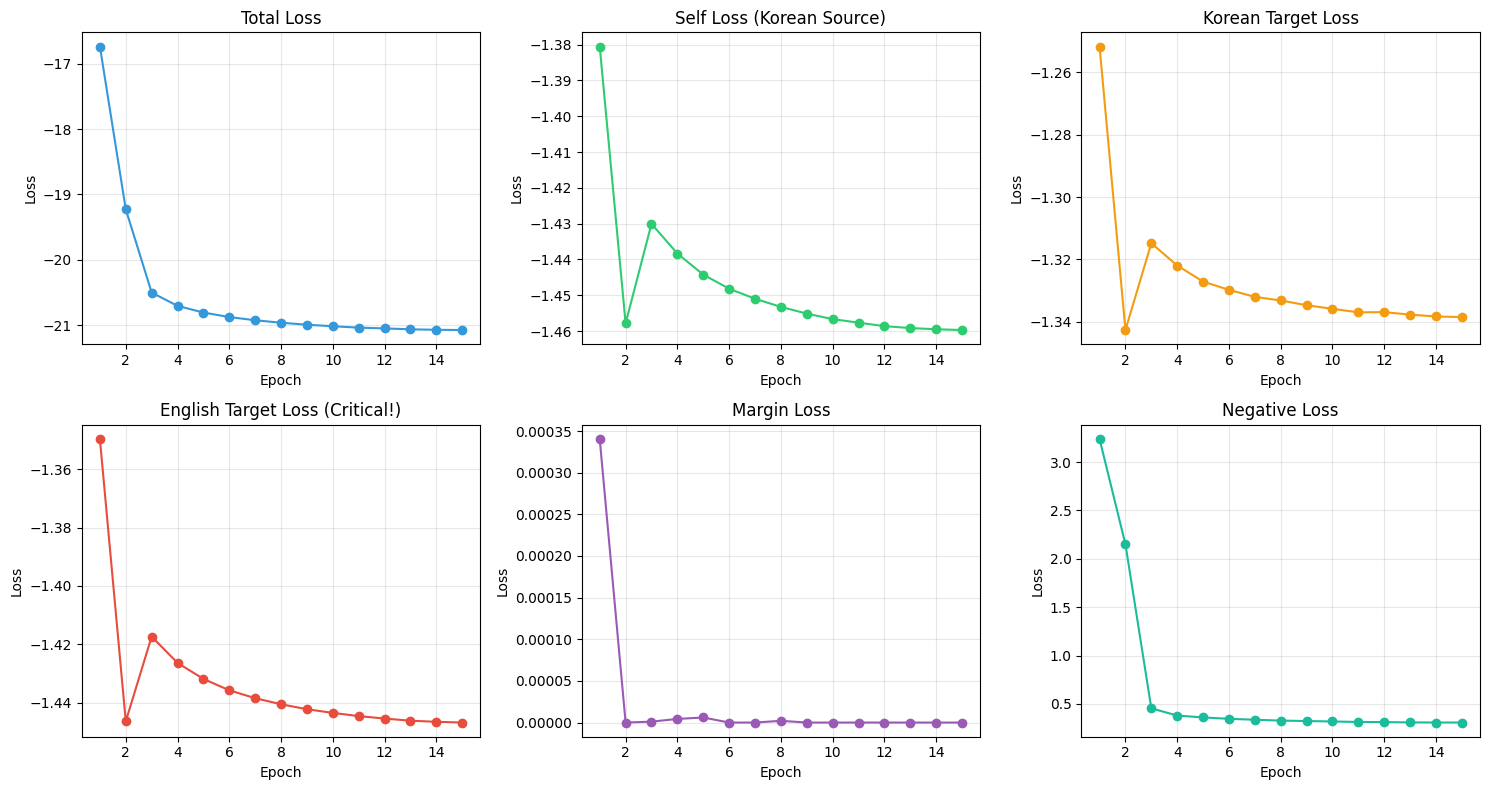

Training curves saved to: /home/west/Documents/cursor-workspace/opensearch-neural-pre-train/outputs/v19_xlm_large/training_curves.png


In [17]:
import matplotlib.pyplot as plt

# Plot training curves
if history:
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))

    epochs = range(1, len(history) + 1)

    # Total loss
    axes[0, 0].plot(epochs, [h['total'] for h in history], '-o', color='#3498db')
    axes[0, 0].set_title('Total Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].grid(True, alpha=0.3)

    # Self loss
    axes[0, 1].plot(epochs, [h['self'] for h in history], '-o', color='#2ecc71')
    axes[0, 1].set_title('Self Loss (Korean Source)')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].grid(True, alpha=0.3)

    # Korean target loss
    axes[0, 2].plot(epochs, [h['ko_target'] for h in history], '-o', color='#f39c12')
    axes[0, 2].set_title('Korean Target Loss')
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('Loss')
    axes[0, 2].grid(True, alpha=0.3)

    # English target loss (CRITICAL!)
    axes[1, 0].plot(epochs, [h['en_target'] for h in history], '-o', color='#e74c3c')
    axes[1, 0].set_title('English Target Loss (Critical!)')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].grid(True, alpha=0.3)

    # Margin loss
    axes[1, 1].plot(epochs, [h['margin'] for h in history], '-o', color='#9b59b6')
    axes[1, 1].set_title('Margin Loss')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Loss')
    axes[1, 1].grid(True, alpha=0.3)

    # Negative loss
    axes[1, 2].plot(epochs, [h['negative'] for h in history], '-o', color='#1abc9c')
    axes[1, 2].set_title('Negative Loss')
    axes[1, 2].set_xlabel('Epoch')
    axes[1, 2].set_ylabel('Loss')
    axes[1, 2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(CONFIG["output_dir"] / "training_curves.png", dpi=150)
    plt.show()
    
    print(f"Training curves saved to: {CONFIG['output_dir'] / 'training_curves.png'}")

## Next Steps

After training completes:

1. **Run inference tests** using `03_inference_test.ipynb`
2. **Verify both Korean AND English activation rates**
3. **Fine-tune lambda_en_target if English rate is still low**

### Key Fix: Separate Korean/English Losses

The critical change in this version:

| Loss Component | Weight | Purpose |
|----------------|--------|---------|
| `lambda_self` | 2.0 | Preserve Korean source tokens |
| `lambda_ko_target` | 3.0 | Activate Korean synonym tokens |
| `lambda_en_target` | **10.0** | Activate English translation tokens |
| `lambda_margin` | 3.0 | Ensure minimum activation |

**Why English needs 3.3x higher weight:**
- Korean targets share subword tokens with Korean input → easy to learn
- English targets require cross-lingual transfer → hard to learn
- Without explicit high weight, the model ignores English entirely

### Best Model Selection

The best model is now selected by: `score = KO_rate + 2 * EN_rate`

This prioritizes English activation since it's the harder and more important task for cross-lingual search.